<a href="https://colab.research.google.com/github/Ete-Bosh/HappyCrab_docker_network/blob/master/pcds_activity4a_game_of_life.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np

# small_exploder pattern
small_exploder = np.array([[0,1,0],[1,1,1],[1,0,1],[0,1,0]], dtype=np.uint8)

## `dask` game of life

The goal of this activity is to learn to program dask arrays with partitioned overlap for lock-step time-series simulation with geometric decomposition. This is a common paradigm for programming in the sciences.
* dask arrays -- grid is partitioned into chunks
* overlap -- chunks share boundary or ghost cells
* lock-step time-series simulation -- every cell updates at every point in time. Same computation model as finite-difference simulation or direct numerical simulation.
* geometric decomposition -- parallel programming lingo for breaking stuff into chunks, i.e. decompose the data which defines parallel tasks

We will explore these issues in a simulation of cellular automata. Cellular automata are of wide interest. Wolfram puts forth that simple automata exhibit the complexity that underlies natural phenomena. This is tenet of the field of digital physics (http://en.wikipedia.org/wiki/Cellular_automata).

To keep it simple, we will focus on Conway’s game of life. One of the earliest and best studied 2-d cellular automata.

### Game of Life

The following resources may be helpful in understanding the game of life.

* http://psoup.math.wisc.edu/mcell/whatis_life.html gives a simple and intuitive description of the rules of Life and how to evaluate them on a grid.
* http://www.bitstorm.org/gameoflife/ provides another description of the game of life. The applet there includes many common life patterns that you may use to evaluate your code. We will use the glider pattern

### Demo without dask

The following example shows the "small exploder" pattern run on a NumPy array. The function that evaluates the rules is designed so that it will work in a dask distributed implementation with one cell of overlap or one ghost cell.  More on this later.  For now, this function computes the rules for all internal cells.

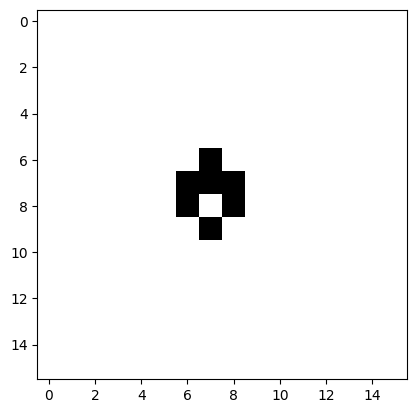

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

grid = np.zeros((16,16), dtype=np.uint8)
grid[6:small_exploder.shape[0]+6,6:small_exploder.shape[1]+6] = small_exploder

plt.imshow(grid, cmap='Greys', interpolation='nearest')
plt.show()

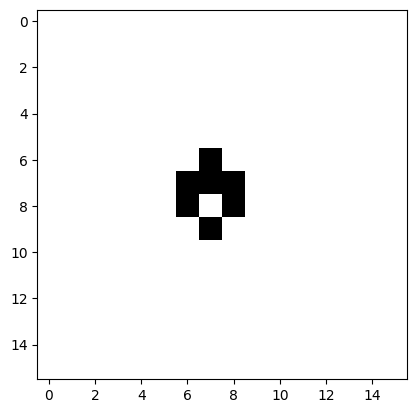

NameError: name 'rules_of_life' is not defined

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

"""mini-demo: no dask.  Start the small exploder in center and iterate."""
grid = np.zeros((16,16), dtype=np.uint8)
grid[6:small_exploder.shape[0]+6,6:small_exploder.shape[1]+6] = small_exploder

plt.imshow(grid, cmap='Greys', interpolation='nearest')
plt.show()

for i in range(20):
    grid = rules_of_life(grid)
    plt.imshow(grid, cmap='Greys', interpolation='nearest')
    plt.show()

### Ghost cells

In the next steps, we are going to take a 16x16 grid and break it into 4 adjacent 8x8 grids. Because the rules of life requires neighbors, we are going to have to use [_ghost cells_](http://fredrikbk.com/publications/ghost_cell_pattern.pdf). This diagram (6x6) shows that the center of the chunk (green) is bordered by cells shared with one other chunk on the sides (blue) and cells shared with three other chunks on the corners (red).

![this](https://www.olcf.ornl.gov/wp-content/uploads/2013/09/domainWithGhostZones.png)

## Activity 4a: Distributed Game of Life

The exercise is to create a grid of 16x16 in 4 chunks with one cell of overlap in dask and then demonstrate that you can sucessfully transfer the glider from parallel chunks.  I have given you a NumPy array with the glider pattern.  The glider pattern will move down 1 and over 1 cell every four iterations.  Thus, it will return to it's original location every 64 iterations.  You must:
* build a dask array of 4 8x8 chunks
* iterate using the provided loop
  * build an overlapping grid with cyclic boundary conditions
  * apply the rules of life to each chunks
  * trim the expanded chunks to their original 8x8 size

In [ ]:
# glider pattern
glider = np.array([[0,1,0],[0,0,1],[1,1,1]], dtype=np.uint8)
plt.imshow(glider, cmap='Greys', interpolation='nearest')
plt.show()

In [ ]:
import dask.array as da

# put the glider in the top corner of a 16x16 grid
grid = np.zeros((16,16), dtype=np.uint8)
grid[0:glider.shape[0],0:glider.shape[1]] = glider

# build a dask array of 4 8x8 chunks
dagrid = da.from_array(grid, chunks=(8, 8))

# display the grid metadata
dagrid

In [ ]:
# print the contents: see the glider
plt.imshow(dagrid, cmap='Greys', interpolation='nearest')
plt.show()

In [ ]:
# 64 total iterations to repeat
for i in range(16):
    # glider shape repeats every 4 steps --
    for i in range(4):

        # define overlappings region for stencil computations
        # TODO ...

        # update the regions in parallel
        # TODO ...

        # trim the chunks and rebuild the overlap
        # TODO ...

    # print every fourth cycle -- should still look like a glider
    plt.imshow(dagrid, cmap='Greys', interpolation='nearest')
    plt.show()

        
### Questions:
    
1. Why is it necessary to trim the chunks and rebuild the overlap?

2. Why is the dask approach to building the overlap _declarative_?  

In [ ]:
def rules_of_life(subgrid):
    """Evaluate the rules of life on a 2-d subarray.
    The array should have an overlap of 1 cell in all dimension
    and on the corner.

    Args:
        subgrid (ndarray): Input array

    Returns:
        outgrid (ndarray): Array updated by rules of life
    """
    # we will receive an array with 1 dimension of padding
    xdim, ydim = subgrid.shape

    # output array to keep updates
    outgrid = np.zeros(shape=subgrid.shape, dtype=subgrid.dtype)

    # update only in center (non-overlapping) regaion
    for x in range(1,xdim-1):
        for y in range(1, ydim-1):
            sum = subgrid[x-1,y-1] + subgrid[x,y-1] + subgrid[x+1,y-1] +\
                  subgrid[x-1,y]   + subgrid[x+1,y] +\
                  subgrid[x-1,y+1] + subgrid[x,y+1] + subgrid[x+1,y+1]
            # three neighbors birth
            if (sum == 3):
                outgrid[x,y] = 1
            # two neighbors no change
            elif (sum == 2):
                outgrid[x,y] = subgrid[x,y]
            # <2 or >3 death
            else:
                outgrid[x,y] = 0

    return outgrid